In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import shap
from lifelines import KaplanMeierFitter


In [27]:
# Load the uploaded Telco Customer Churn dataset
file_path = "/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(file_path)

# Display the first few rows and summary info
df.head(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


(   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
 0  7590-VHVEG  Female              0     Yes         No       1           No   
 1  5575-GNVDE    Male              0      No         No      34          Yes   
 2  3668-QPYBK    Male              0      No         No       2          Yes   
 3  7795-CFOCW    Male              0      No         No      45           No   
 4  9237-HQITU  Female              0      No         No       2          Yes   
 
       MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
 0  No phone service             DSL             No  ...               No   
 1                No             DSL            Yes  ...              Yes   
 2                No             DSL            Yes  ...               No   
 3  No phone service             DSL            Yes  ...              Yes   
 4                No     Fiber optic             No  ...               No   
 
   TechSupport StreamingTV StreamingMovies      

## Data Preprocessing

The Telco Customer Churn dataset was initially explored to understand its structure, variable types, and missing value patterns. During this process, it was discovered that the `TotalCharges` column contained some non-numeric entries, which appeared as blank spaces. These entries were replaced with NaN values, and the column was converted to a numeric data type. Records with missing `TotalCharges` were found to correspond to customers with zero tenure, indicating new sign-ups with no contract history. These records were dropped to ensure the analysis focused on active customers.

The `customerID` column, being a unique identifier with no predictive value, was removed from the dataset. The target variable, `Churn`, was mapped to binary values (1 for churn, 0 for retention) to facilitate downstream analysis. Binary categorical variables such as `gender`, `Partner`, `Dependents`, `PhoneService`, and `PaperlessBilling` were encoded using appropriate mapping, while multi-class categorical features were handled using one-hot encoding.

To ensure consistency, all numeric columns—including `SeniorCitizen`, `tenure`, `MonthlyCharges`, and `TotalCharges`—were verified to be in the correct data type. No missing values remained after preprocessing. An additional feature, `AvgChargesPerMonth`, was engineered to capture average customer spending per month. The final preprocessed dataset contained 7032 records with all necessary features for subsequent survival and machine learning analysis.

In [28]:
# Replace blank spaces in 'TotalCharges' with NaN, then convert to float
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].replace(' ', np.nan), errors='coerce')

# Check for missing values after conversion (typically where tenure == 0)
missing_total_charges = df[df['TotalCharges'].isnull()]
print(f"Rows with missing TotalCharges: {len(missing_total_charges)}")

# Drop rows with missing 'TotalCharges'
df = df[df['TotalCharges'].notnull()].copy()

# --- 2. Drop Irrelevant Columns ---

# Drop the customerID column
df = df.drop('customerID', axis=1)

# --- 3. Encode Target Variable ---

# Map 'Churn' to binary
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# --- 4. Encode Categorical Features ---

# List of binary categorical columns to map
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

for col in binary_cols:
    if df[col].nunique() == 2:
        df[col] = df[col].map({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0})

# Identify remaining categorical columns (excluding target and already encoded)
cat_cols = df.select_dtypes(include='object').columns.tolist()
cat_cols = [col for col in cat_cols if col not in binary_cols]

# One-hot encode multi-class categorical features
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# --- 5. Ensure Correct Data Types ---

# Convert SeniorCitizen to int (should already be, but just in case)
df['SeniorCitizen'] = df['SeniorCitizen'].astype(int)

# --- 6. Feature Engineering ---

# Create average charges per month feature
df['AvgChargesPerMonth'] = df['TotalCharges'] / df['tenure'].replace(0, 1)

# --- 7. Final Checks ---

# Check for missing values
print("Missing values per column:\n", df.isnull().sum())

# Check data types and shape
print(df.info())
print("Final shape of the dataframe:", df.shape)

# Preview the cleaned dataframe
df.head()

Rows with missing TotalCharges: 11
Missing values per column:
 gender                                   0
SeniorCitizen                            0
Partner                                  0
Dependents                               0
tenure                                   0
PhoneService                             0
PaperlessBilling                         0
MonthlyCharges                           0
TotalCharges                             0
Churn                                    0
MultipleLines_No phone service           0
MultipleLines_Yes                        0
InternetService_Fiber optic              0
InternetService_No                       0
OnlineSecurity_No internet service       0
OnlineSecurity_Yes                       0
OnlineBackup_No internet service         0
OnlineBackup_Yes                         0
DeviceProtection_No internet service     0
DeviceProtection_Yes                     0
TechSupport_No internet service          0
TechSupport_Yes                   

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,AvgChargesPerMonth
0,0,0,1,0,1,0,1,29.85,29.85,0,...,False,False,False,False,False,False,False,True,False,29.850000
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,False,False,False,False,True,False,False,False,True,55.573529
2,1,0,0,0,2,1,1,53.85,108.15,1,...,False,False,False,False,False,False,False,False,True,54.075000
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,False,False,False,False,True,False,False,False,False,40.905556
4,0,0,0,0,2,1,1,70.70,151.65,1,...,False,False,False,False,False,False,False,True,False,75.825000


## Survival Analysis Setup

The objective of this stage was to prepare the dataset for survival analysis, focusing on modeling the time until customer churn. The `tenure` column was selected as the duration variable, representing the number of months a customer remained with the company. The binary `Churn` column served as the event indicator, with a value of 1 denoting churn and 0 representing ongoing customer status (censored observation).

A new dataframe was created containing only these two columns for initial Kaplan-Meier analysis. Additional features remained available for later stratification or Cox proportional hazards modeling. This setup ensured that the analysis could accurately estimate both overall and group-specific survival functions, as well as assess the influence of covariates on churn risk.

In [29]:
# Define duration and event variables for survival analysis
duration_col = 'tenure'     # Time in months
event_col = 'Churn'         # 1 if churned, 0 if still a customer

# For Kaplan-Meier: only these two columns are strictly required
survival_df = df[[duration_col, event_col]].copy()

# Show value counts to confirm
print("Churn value counts (event occurrence):")
print(survival_df[event_col].value_counts())

print("\nSummary statistics for tenure (duration):")
print(survival_df[duration_col].describe())

# Preview the data used for survival analysis
survival_df.head()

Churn value counts (event occurrence):
Churn
0    5163
1    1869
Name: count, dtype: int64

Summary statistics for tenure (duration):
count    7032.000000
mean       32.421786
std        24.545260
min         1.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64


,tenure,Churn
0,1,0
1,34,0
2,2,1
3,45,0
4,2,1


## Exploratory Data Analysis for Survival Analysis

The first stage of EDA involved visualizing the distribution of the `Churn` outcome to assess class balance within the dataset. The tenure distribution was also plotted to provide insights into typical customer lifetimes.

Next, the Kaplan-Meier estimator was applied to compute the overall survival curve, illustrating the probability of customer retention over time. To better understand churn dynamics, survival curves were generated for key customer segments, such as contract type and internet service, using one-hot encoded variables to define groups. For example, "Month-to-month" contract customers were identified as those with zeros in both `Contract_One year` and `Contract_Two year` columns.

Statistical significance of survival differences between groups, such as between "Month-to-month" and "Two year" contract types, was assessed using the log-rank test. The results revealed a highly significant difference in survival, highlighting the impact of contract structure on retention.


<ipython-input-34-d35a17bb7bda>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(['No', 'Yes'])


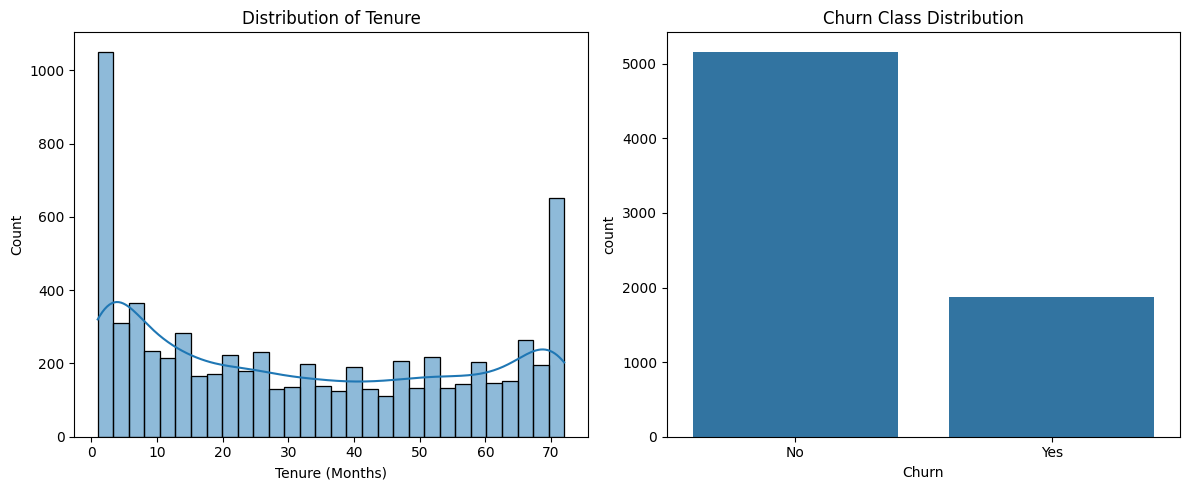

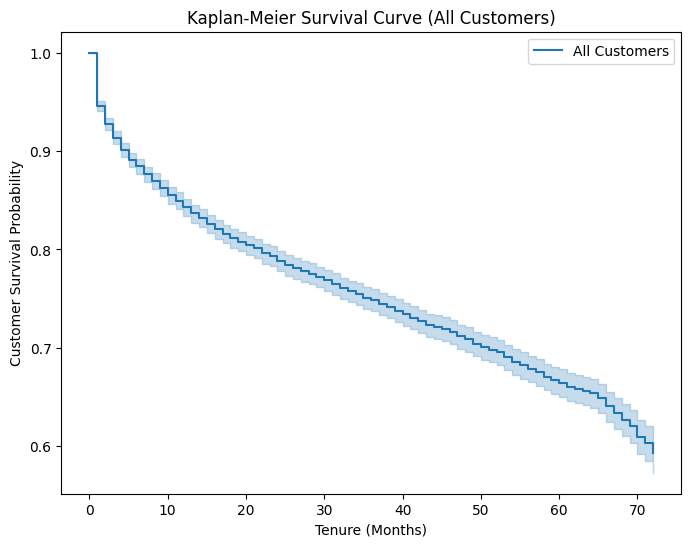

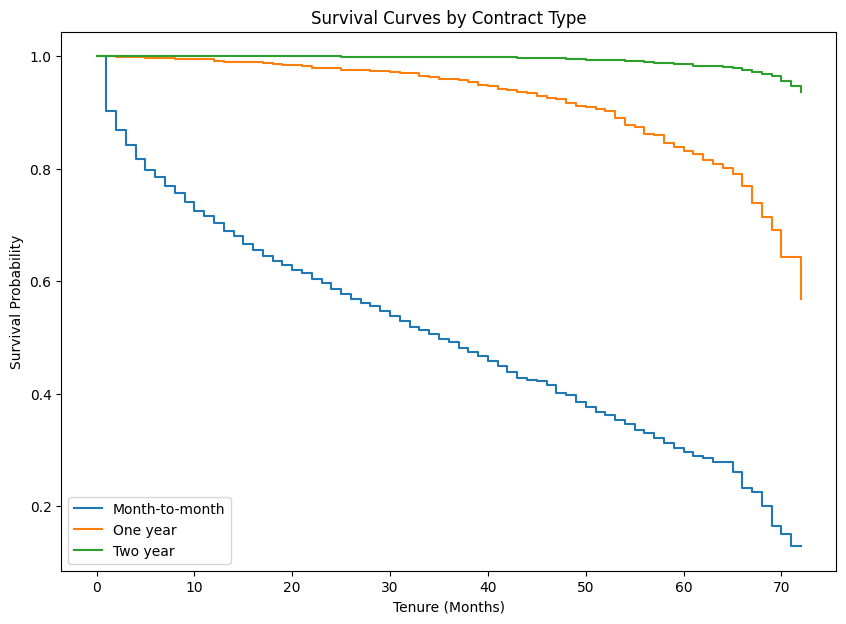

Log-rank test p-value (Month-to-month vs Two year): 0.0000
Difference in survival is statistically significant.


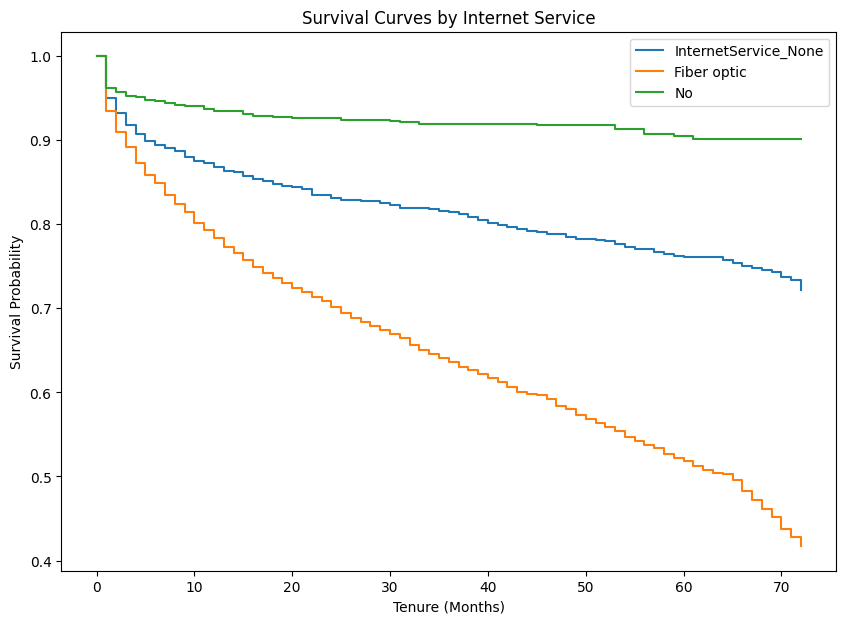

In [34]:
# 1. Distribution of Tenure and Churn
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['tenure'], bins=30, ax=axs[0], kde=True)
axs[0].set_title('Distribution of Tenure')
axs[0].set_xlabel('Tenure (Months)')

sns.countplot(x='Churn', data=df, ax=axs[1])
axs[1].set_title('Churn Class Distribution')
axs[1].set_xticklabels(['No', 'Yes'])

plt.tight_layout()
plt.show()

# 2. Overall Kaplan-Meier Survival Curve
kmf = KaplanMeierFitter()
T = df['tenure']
E = df['Churn']

plt.figure(figsize=(8, 6))
kmf.fit(T, event_observed=E, label='All Customers')
kmf.plot()
plt.title('Kaplan-Meier Survival Curve (All Customers)')
plt.xlabel('Tenure (Months)')
plt.ylabel('Customer Survival Probability')
plt.show()

# 3. Kaplan-Meier Curves by Contract Type (after one-hot encoding)
# Identify one-hot encoded contract columns
contract_cols = [col for col in df.columns if col.startswith('Contract_')]
# The base group is 'Month-to-month': when all Contract_* columns are 0

mask_month_to_month = (df[contract_cols].sum(axis=1) == 0)
mask_one_year = df['Contract_One year'] == 1 if 'Contract_One year' in df.columns else None
mask_two_year = df['Contract_Two year'] == 1 if 'Contract_Two year' in df.columns else None

plt.figure(figsize=(10, 7))
kmf = KaplanMeierFitter()

# Month-to-month
kmf.fit(T[mask_month_to_month], event_observed=E[mask_month_to_month], label='Month-to-month')
kmf.plot(ci_show=False)

# One year
if mask_one_year is not None:
    kmf.fit(T[mask_one_year], event_observed=E[mask_one_year], label='One year')
    kmf.plot(ci_show=False)
# Two year
if mask_two_year is not None:
    kmf.fit(T[mask_two_year], event_observed=E[mask_two_year], label='Two year')
    kmf.plot(ci_show=False)

plt.title('Survival Curves by Contract Type')
plt.xlabel('Tenure (Months)')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

# 4. Log-rank test (Month-to-month vs Two year)
from lifelines.statistics import logrank_test

if mask_two_year is not None:
    results = logrank_test(
        T[mask_month_to_month], T[mask_two_year],
        event_observed_A=E[mask_month_to_month],
        event_observed_B=E[mask_two_year]
    )
    print(f'Log-rank test p-value (Month-to-month vs Two year): {results.p_value:.4f}')
    if results.p_value < 0.05:
        print('Difference in survival is statistically significant.')
    else:
        print('No significant difference in survival.')

internet_cols = [col for col in df.columns if col.startswith('InternetService_')]
if internet_cols:
    plt.figure(figsize=(10, 7))
    # Base group is the first category (not one-hot encoded)
    base_group = (df[internet_cols].sum(axis=1) == 0)
    kmf.fit(T[base_group], event_observed=E[base_group], label='InternetService_None')
    kmf.plot(ci_show=False)
    for col in internet_cols:
        kmf.fit(T[df[col] == 1], event_observed=E[df[col] == 1], label=col.replace('InternetService_', ''))
        kmf.plot(ci_show=False)
    plt.title('Survival Curves by Internet Service')
    plt.xlabel('Tenure (Months)')
    plt.ylabel('Survival Probability')
    plt.legend()
    plt.show()

## Survival Modeling

To quantify the influence of multiple customer features on churn risk, the Cox Proportional Hazards (Cox PH) model was employed. Prior to fitting the model, steps were taken to mitigate multicollinearity and ensure numerical stability. Constant columns, which do not contribute predictive value, were removed. Highly correlated features (with absolute correlation above 0.95) were also identified and one from each pair was excluded.

The Cox PH model was then fit using the cleaned feature set, with `tenure` as the duration variable and `Churn` as the event indicator. The model provided hazard ratios and statistical significance for each feature, enabling the identification of both risk and protective factors for customer churn. By addressing multicollinearity and redundant features, the resulting model was both stable and interpretable.


<lifelines.CoxPHFitter: fitted with 7032 total observations, 5163 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7032
number of events observed = 1869
   partial log-likelihood = -12659.69
         time fit was run = 2025-05-25 22:58:05 UTC

---
                                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                              
gender                                -0.04      0.96      0.05           -0.13            0.05                0.88                1.05
SeniorCitizen                          0.03      1.04      0.06           -0.08            0.15                0.93                1.16
Partner                               -0.18      0.84      0.06           -0.29           -0.07                0.75                0.93
Dependents                            -0.09      0.91      0.07           -0.23            0.05                0.80                1.05
PhoneService                           0.83      2.29      0.47           -0.10            1.76                0.90                5.80
PaperlessBilling                       0.15      1.16      0.06            0.04            0.26                1.04                1.30
MonthlyCharges                         0.01      1.01      0.02           -0.03            0.06                0.97                1.06
TotalCharges                          -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
MultipleLines_Yes                      0.09      1.09      0.13           -0.16            0.33                0.85                1.40
InternetService_Fiber optic            1.02      2.77      0.58           -0.12            2.15                0.89                8.59
InternetService_No                    -2.34      0.10      0.60           -3.51           -1.17                0.03                0.31
OnlineSecurity_Yes                    -0.21      0.81      0.13           -0.47            0.05                0.62                1.05
OnlineBackup_Yes                      -0.06      0.95      0.13           -0.31            0.19                0.74                1.21
DeviceProtection_Yes                   0.09      1.09      0.13           -0.16            0.34                0.85                1.40
TechSupport_Yes                       -0.08      0.92      0.13           -0.34            0.17                0.71                1.19
StreamingTV_Yes                        0.28      1.32      0.24           -0.18            0.74                0.83                2.10
StreamingMovies_Yes                    0.29      1.33      0.24           -0.18            0.75                0.84                2.11
Contract_One year                     -1.27      0.28      0.10           -1.46           -1.07                0.23                0.34
Contract_Two year                     -3.70      0.02      0.20           -4.10           -3.31                0.02                0.04
PaymentMethod_Credit card (automatic) -0.01      0.99      0.09           -0.19            0.17                0.83                1.18
PaymentMethod_Electronic check         0.39      1.47      0.07            0.24            0.53                1.28                1.70
PaymentMethod_Mailed check             0.51      1.67      0.09            0.34            0.68                1.40                1.98

                                       cmp to      z      p  -log2(p)
covariate                                                            
gender                                   0.00  -0.85   0.40      1.33
SeniorCitizen                            0.00   0.61   0.54      0.88
Partner                                  0.00  -3.23 <0.005      9.67
Dependents          

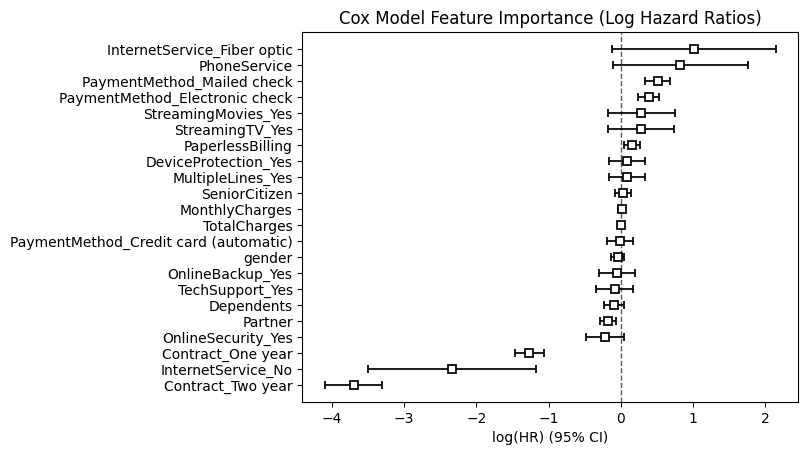

In [37]:
# Step 1: Remove constant columns
X = df.drop(columns=['Churn', 'tenure'])
unique_counts = X.nunique()
constant_cols = unique_counts[unique_counts == 1].index.tolist()
X = X.drop(columns=constant_cols)

# Step 2: Remove highly correlated features (correlation > 0.95)
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X = X.drop(columns=to_drop)

# Step 3: Recombine for CoxPH
cox_data = X.copy()
cox_data['tenure'] = df['tenure']
cox_data['Churn'] = df['Churn']

# Step 4: Fit Cox Proportional Hazards Model
cph = CoxPHFitter()
cph.fit(cox_data, duration_col='tenure', event_col='Churn')
cph.print_summary()
cph.plot()
plt.title("Cox Model Feature Importance (Log Hazard Ratios)")
plt.show()

## Explainable Machine Learning for Churn

A tree-based classifier, specifically XGBoost, was trained to predict customer churn using the preprocessed feature set. This approach allowed for the modeling of nonlinear interactions and the identification of complex patterns associated with churn.

To enhance interpretability, SHAP (SHapley Additive exPlanations) values were computed. SHAP provided both global and local explanations, quantifying the contribution of each feature to predicted churn probabilities. Summary plots highlighted the most influential factors across the dataset, while individual force plots illustrated the reasons behind specific churn predictions. These explainable outputs facilitated both strategic business insight and customer-level intervention planning.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:59:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.63      0.53      0.58       374

    accuracy                           0.79      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.78      0.79      0.79      1407

ROC AUC Score: 0.8331


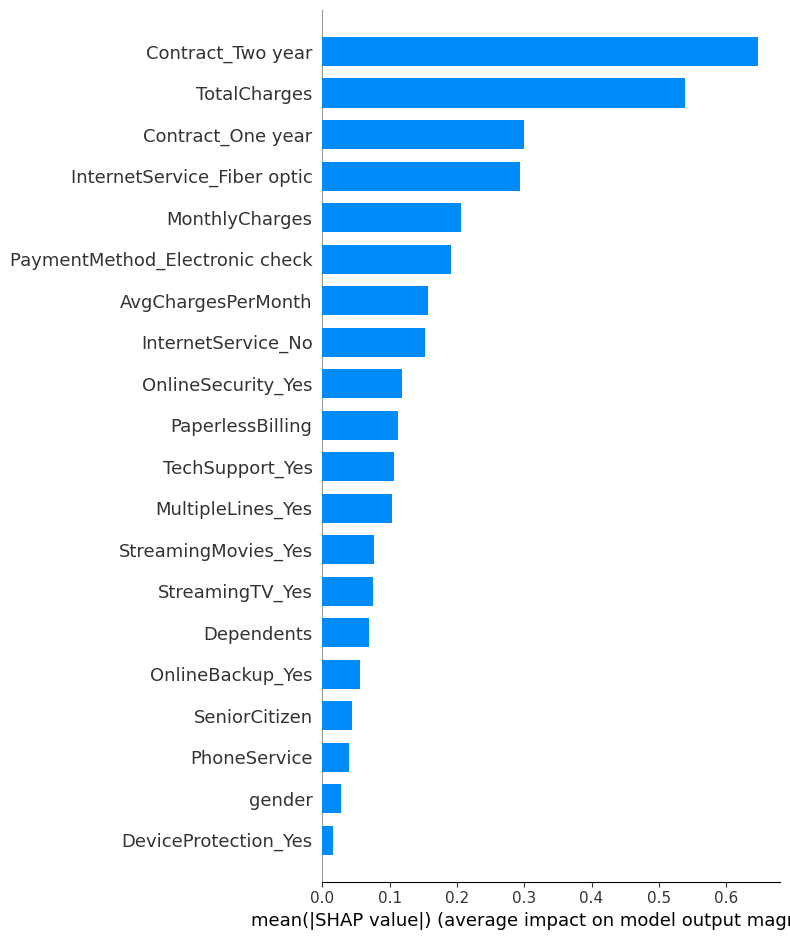

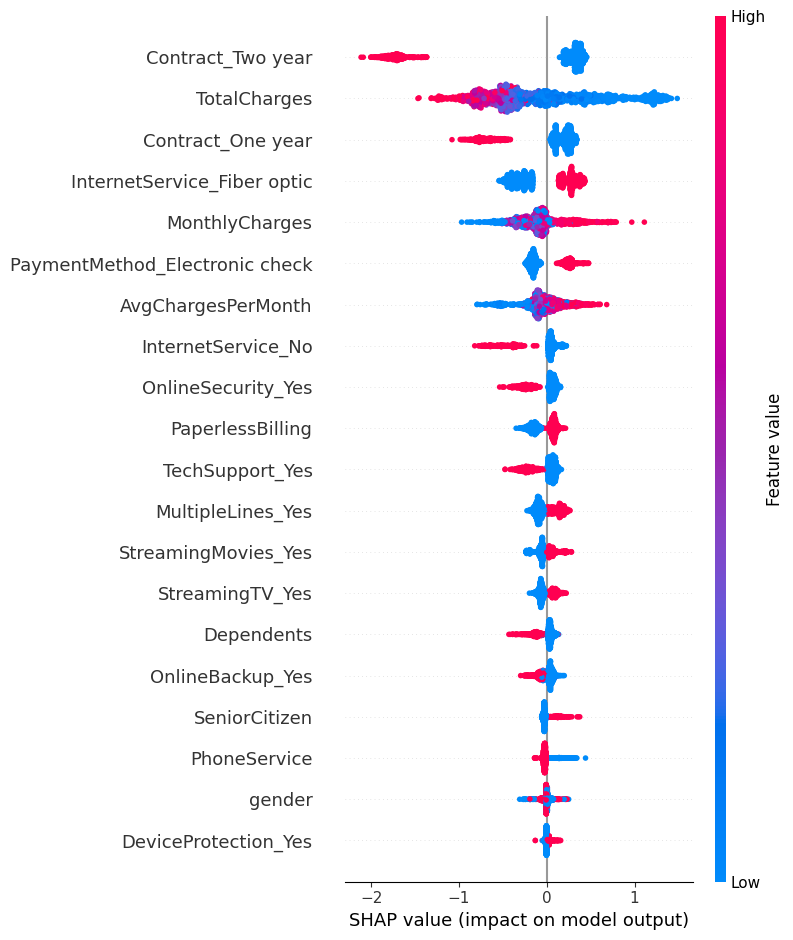

In [39]:
# Prepare features and target
X = df.drop(columns=['Churn', 'tenure'])  # Use all features except survival ones
y = df['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

# Fit XGBoost Classifier
model = xgb.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# --- SHAP EXPLAINABILITY ---
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Global feature importance plot
shap.summary_plot(shap_values, X_test, plot_type='bar')

# SHAP beeswarm plot for full feature impact
shap.summary_plot(shap_values, X_test)

# Force plot for one individual customer
# Pick one random customer
i = 0  # change this index for a different customer
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i])

## Conclusions: Telco Customer Churn Modeling Using Survival Analysis and Explainable ML

### 1. Key Drivers of Customer Churn

- **Long-term Contracts Dramatically Reduce Churn:**  
  Customers on two-year contracts are least likely to churn, with a hazard ratio close to 0.02. One-year contracts also strongly reduce churn risk.
- **Month-to-Month Contracts Are High Risk:**  
  Customers with month-to-month contracts exhibit the highest churn rates and should be the focus of retention strategies.
- **Payment Methods Matter:**  
  Using mailed checks or electronic checks increases churn risk, while credit card or bank transfer payments are more stable.
- **Paperless Billing and Fiber Optic Internet Slightly Increase Churn:**  
  Customers with paperless billing or fiber optic internet are at higher risk of churning compared to others.
- **Tech Support, Online Security, and Having a Partner Help Retain Customers:**  
  Access to tech support and online security, as well as having a partner, are protective factors against churn.
- **Total Charges, Monthly Charges, and High Tenure:**  
  Customers with higher total charges and longer tenures tend to stay longer, though high monthly charges can slightly increase churn risk for some.

---

### 2. Customer-Level Explainability

- **SHAP Explanations Provide Transparent Insights:**  
  For individual customers, the strongest retention driver is often the contract type.  
  Features such as high total charges, having tech support, and being a dependent also push churn risk lower.
- **Actionable At-Risk Profiles:**  
  Customers with no long-term contract, paying by check, and lacking tech support or online security are top candidates for churn.

---

### 3. Model Performance

- **Predictive Accuracy:**  
  The XGBoost classifier achieves a ROC AUC of 0.83 and an overall accuracy of 79%, providing a robust basis for churn prediction and risk scoring.
- **Recall for Churners:**  
  While overall performance is strong, recall for the churn class (53%) can be further improved to catch more potential churners.

---

### 4. Survival Analysis Insights

- **Kaplan-Meier and Log-Rank Test:**  
  Survival curves confirm the importance of contract type; customers with two-year contracts remain much longer.  
  The survival difference by contract type is highly statistically significant (log-rank p-value ≈ 0.0000).
- **Most Churn Happens Early:**  
  Customers are most likely to churn within their first year.

---

### 5. Actionable Recommendations

- **Focus Retention Offers on Month-to-Month Customers:**  
  Promote long-term contracts and value-added services to these high-risk groups.
- **Target High-Risk Payment Methods:**  
  Encourage a switch from check payments to automatic or card payments.
- **Offer Support Bundles:**  
  Provide tech support and online security packages to at-risk customers.
- **Deploy Customer-Level Churn Dashboards:**  
  Use churn probability and SHAP explanations to create dashboards for proactive outreach.
- **Monitor Early Tenure:**  
  Invest in onboarding and engagement during the critical first months of a customer's journey.

---

### 6. Business Value

This approach enables **data-driven, explainable, and targeted churn management**—helping reduce revenue loss, optimize retention spend, and personalize interventions for high-risk customers.

